## Import Packages

In [2]:
using JuMP;
using Plots;
using HiGHS;
using CSV;
using DataFrames;

## Load Data

In [3]:
data = CSV.read("MER_T07_01.csv", DataFrame);
YYYYMM = data[!,"YYYYMM"];
index = mod.(YYYYMM,100) .!= 13;
Value = data[!,"Value"];
y = parse.(Float64,Value[index][1:588]);
y = y[1:132];
n = length(y);

## Tools

In [4]:
function r_square(data::Vector{Float64}, estimative::Vector{Float64})
    output = 1.0
    n = length(data)
    average = sum(data) / n
    
    output = 1.0 - sum((data[i] - estimative[i])^2 for i in 1:n) / sum((data[i] - average)^2 for i in 1:n) 

    return output
end

function mae(data::Vector{Float64}, estimative::Vector{Float64}, T::Int)
    output = 0.0

    K = length(data) - T
      
    for i in (T+1):(T+K)
        output += abs(data[i] - estimative[i]) / K
    end
    
    return output
end

function forecast(data::Vector{Float64}, K::Vector{Int} = [1], S::Vector{Int} = [8760], M::Vector{Int} = [1], T::Int = 0, B::Int64 = 1, BigM::Float64 = 1e3)
    model = complete_model(data[1:T], K, S, M, B, BigM)

    beta = value.(model[:beta])
    theta = value.(model[:theta])
    phi = value.(model[:phi])

    n_forecast = length(data) - T

    output = copy(data)
    n = length(beta) - 1
    m = length(S)

    for i in 1:n_forecast #T+1:length(data)
        AR = beta[1] + sum(beta[j+1]*output[T + i - K[j]] for j = 1:n)
        ST = sum(sum(theta[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*cos(2*pi*k*(T+i)/S[j]) + 
            phi[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*sin(2*pi*k*(T+i)/S[j]) 
            for k in 1:M[j]) for j = 1:m)
        output[T+i] = AR + ST
    end

    return output, model
end

function L(data::Vector{Float64}, k::Int = 0)
    x = data[1:end-k]
    y = data[k+1:end]

    return x, y
end

function plot_shift(data::Vector{Float64}, k::Int = 0)
    x, y = L(data, k)
    p = plot(x, y, seriestype = :scatter, title = "k = $k")

    return p
end

plot_shift (generic function with 2 methods)

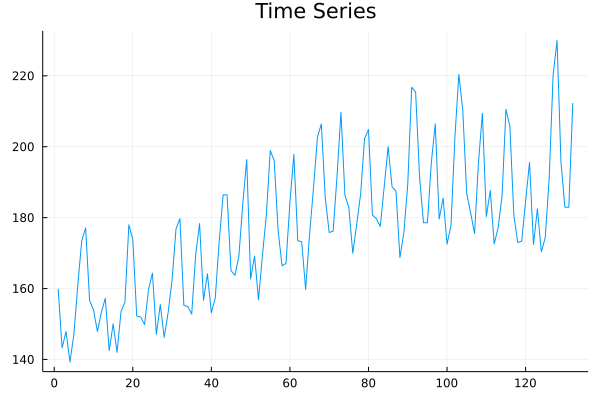

In [5]:
plot(y,title = "Time Series", legend = false)

## AUTOREGRESSIVE MODEL

In [6]:
function auto_regression_model(data::Vector{Float64}, K::Vector{Int} = [1], B::Int64 = 1, BigM::Float64 = 1e3)

    n = length(K)
    N = length(data)
    k_max = maximum(K)

    model = Model(HiGHS.Optimizer)
    MOI.set(model, JuMP.MOI.Silent(), true)
    @variable(model, beta[1:n+1])
    @variable(model, λ[1:n], Bin)
    @variable(model, error[1:N-k_max])

    @expression(model, AR[i = 1:N-k_max], 
        beta[1] + 
        sum(beta[j+1]*data[i + k_max - K[j]] for j = 1:n))

    @constraint(model,[i = 1:n], -BigM*λ[i] <= beta[i+1])
    @constraint(model,[i = 1:n], BigM*λ[i] >= beta[i+1])
    @constraint(model, sum(λ) <= B)
    @constraint(model, [i = 1:N-k_max], error[i] >= + data[i + k_max] - AR[i] )
    @constraint(model, [i = 1:N-k_max], error[i] >= - data[i + k_max] + AR[i] )

    @objective(model, Min, sum(error))

    optimize!(model)
    
    return model
end

auto_regression_model (generic function with 4 methods)

value.(model[:beta]) = [2.305080749469313, 0.19491925661229376, -0.0, -0.0, 0.8114604495454811]


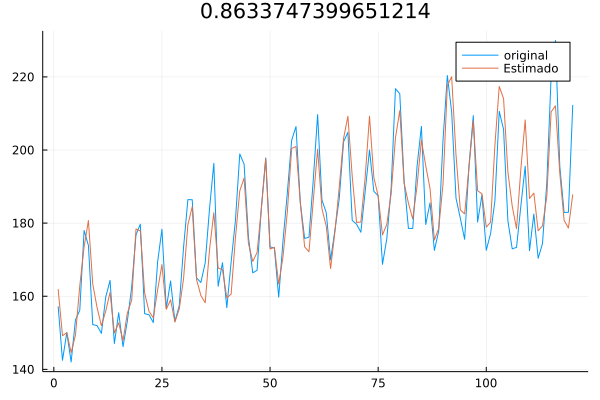

In [7]:
model = auto_regression_model(y,[1, 2, 11, 12],2)
AR = value.(model[:AR])
@show(value.(model[:beta]))
r = r_square(y[13:end], AR)
plot([y[13:end], AR], label=["original" "Estimado"], title="$r")

value.(model[:beta]) = [4.68174275440872, 0.22998468092839086, -0.053842289814287986, -0.01968599972206034, 0.8374091968774543]


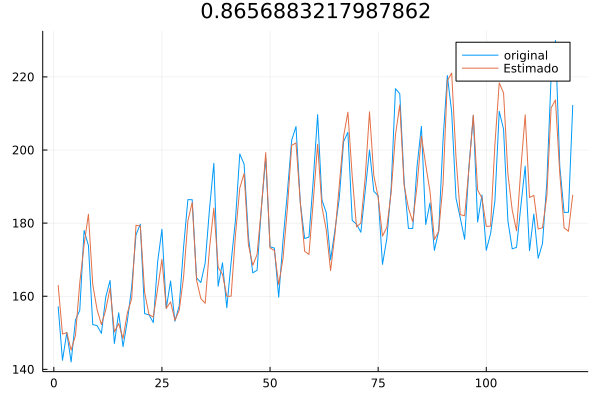

In [8]:
model = auto_regression_model(y,[1, 2, 11, 12],2,1e6)
AR = value.(model[:AR])
@show(value.(model[:beta]))
r = r_square(y[13:end], AR)
plot([y[13:end], AR], label=["original" "Estimado"], title="$r")

## Season Model

In [9]:
function season_model(data::Vector{Float64}, S::Vector{Int} = [8760], M::Vector{Int} = [1],B::Int64 = 1, BigM::Float64 = 1e3)

    N = length(data)
    m = length(S)

    model = Model(HiGHS.Optimizer)
    MOI.set(model, JuMP.MOI.Silent(), true)
    @variable(model, error[1:N])
    @variable(model, theta[1:sum(M)])
    @variable(model, phi[1:sum(M)])
    @variable(model, λ_theta[1:sum(M)], Bin)
    @variable(model, λ_phi[1:sum(M)], Bin)
    @variable(model, level)
        
    @expression(model, ST[i = 1:N], level + sum(sum(
        theta[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*cos(2*pi*k*i/S[j]) + 
        phi[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*sin(2*pi*k*i/S[j]) 
        for k in 1:M[j]) for j = 1:m))
    
    @constraint(model,[i = 1:sum(M)], -BigM*λ_theta[i] <= theta[i])
    @constraint(model,[i = 1:sum(M)], BigM*λ_theta[i] >= theta[i])
    @constraint(model,[i = 1:sum(M)], -BigM*λ_phi[i] <= phi[i])
    @constraint(model,[i = 1:sum(M)], BigM*λ_phi[i] >= phi[i])
    @constraint(model, sum(λ_theta+λ_phi) <= B)

    @constraint(model, [i = 1:N], error[i] >= + data[i] - ST[i])
    @constraint(model, [i = 1:N], error[i] >= - data[i] + ST[i])

    @objective(model, Min, sum(error))

    optimize!(model)
    
    return model
end

season_model (generic function with 5 methods)

value.(model[:theta]) = [5.767238538586158e-13, 0.0, -0.0, 0.0, 0.0, 9.578116078046146e-12, 0.0, 6.588288759509501, 0.0, 0.0]
value.(model[:phi]) = [-6.766866278539913, -1.0132501016034377e-12, 0.0, 0.0, -0.0, 0.0, 0.0, 13.486902288268544, 0.0, 0.0]


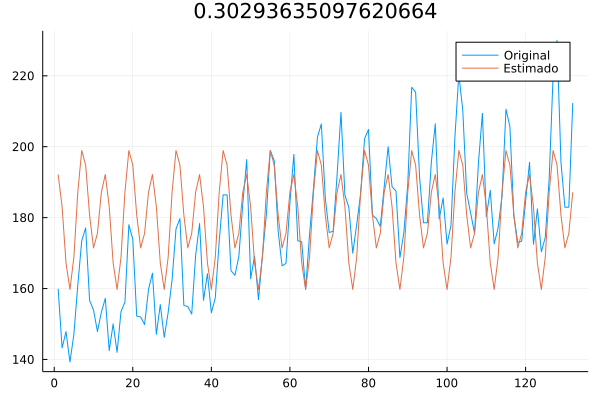

In [10]:
model = season_model(y,[12,18],[5,5],3)
ST = value.(model[:ST])
@show(value.(model[:theta]))
@show(value.(model[:phi]))
r = r_square(y, ST)
plot([y, ST],label=["Original" "Estimado"], title="$r")

value.(model[:theta]) = [-2.400236510809159, 4.4656940268591026, 2.934088235261896, 0.06883027210922109, -1.4643517244527402, 2.4055303302395443, -0.6320586114417999, -0.0, -1.923333867115321, 1.6231954816509195]
value.(model[:phi]) = [-8.53403517517588, 14.178937014523779, 0.5063333333333162, 1.4032761198986254, 4.722368508509194, 1.0241191591076246, 1.5907121322105606, -0.0, -2.3769325880234606, -1.6825925732162508]


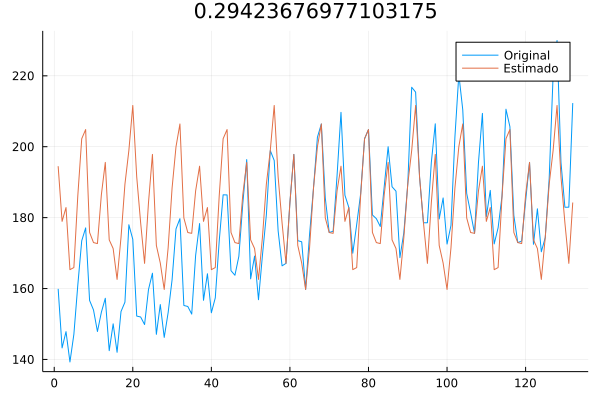

In [11]:
model = season_model(y,[12,18],[5,5],3,1e8)
ST = value.(model[:ST])
@show(value.(model[:theta]))
@show(value.(model[:phi]))
r = r_square(y, ST)
plot([y, ST],label=["Original" "Estimado"], title="$r")

## Complet Model

In [12]:
function complete_model(data::Vector{Float64}, K::Vector{Int} = [1], S::Vector{Int} = [8760], M::Vector{Int} = [1],B::Int64 = 1, BigM::Float64 = 1e3)

    n = length(K)
    N = length(data)
    k_max = maximum(K)
    m = length(S)

    model = Model(HiGHS.Optimizer)
    MOI.set(model, JuMP.MOI.Silent(), true)
    @variable(model, beta[1:n+1])
    @variable(model, λ[1:n], Bin)
    @variable(model, error[1:N-k_max])
    @variable(model, theta[1:sum(M)])
    @variable(model, phi[1:sum(M)])
    @variable(model, λ_theta[1:sum(M)], Bin)
    @variable(model, λ_phi[1:sum(M)], Bin)

    @expression(model, AR[i = 1:N-k_max], 
        beta[1] + 
        sum(beta[j+1]*data[i + k_max - K[j]] for j = 1:n))
        
    @expression(model, ST[i = 1:N-k_max], sum(sum(
        theta[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*cos(2*pi*k*i/S[j]) + 
        phi[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*sin(2*pi*k*i/S[j]) 
        for k in 1:M[j]) for j = 1:m))
    @expression(model, estimate[i = 1:N-k_max], AR[i] + ST[i])
    
    @constraint(model,[i = 1:n], -BigM*λ[i] <= beta[i+1])
    @constraint(model,[i = 1:n], BigM*λ[i] >= beta[i+1])
    @constraint(model,[i = 1:sum(M)], -BigM*λ_theta[i] <= theta[i])
    @constraint(model,[i = 1:sum(M)], BigM*λ_theta[i] >= theta[i])
    @constraint(model,[i = 1:sum(M)], -BigM*λ_phi[i] <= phi[i])
    @constraint(model,[i = 1:sum(M)], BigM*λ_phi[i] >= phi[i])
    @constraint(model, sum(λ)+sum(λ_theta)+sum(λ_phi) <= B)
    @constraint(model, [i = 1:N-k_max], error[i] >= + data[i + k_max] - estimate[i])
    @constraint(model, [i = 1:N-k_max], error[i] >= - data[i + k_max] + estimate[i])

    @objective(model, Min, sum(error))

    optimize!(model)
    
    return model
end

complete_model (generic function with 6 methods)

value.(model[:beta]) = [9.073222471489741, 0.15020729696181928, 0.81692071484943]
value.(model[:theta]) = [-0.0, -2.9117110294012756]
value.(model[:phi]) = [-0.0, -0.0]


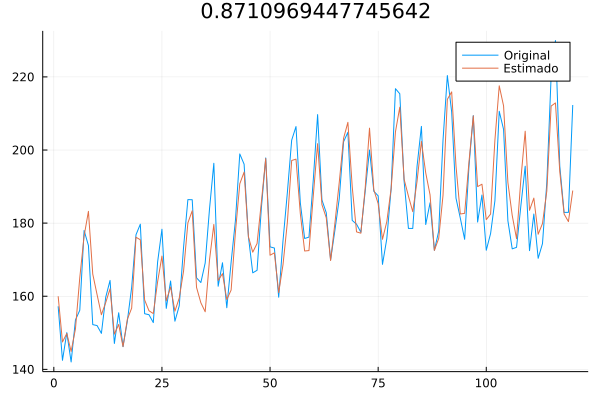

In [13]:
model = complete_model(y,[1,12],[12, 18],[1,1],3,1e3)
ST = value.(model[:estimate])
@show(value.(model[:beta]))
@show(value.(model[:theta]))
@show(value.(model[:phi]))
r = r_square(y[13:end], ST)
plot([y[13:end], ST],label=["Original" "Estimado"], title="$r")

value.(model[:beta]) = [9.069649131535208, 0.14129208699585077, 0.8269622218008449]
value.(model[:theta]) = [-1.0977904376845486, -2.1375868949822276]
value.(model[:phi]) = [-0.9811174096990994, 0.5112448692620889]


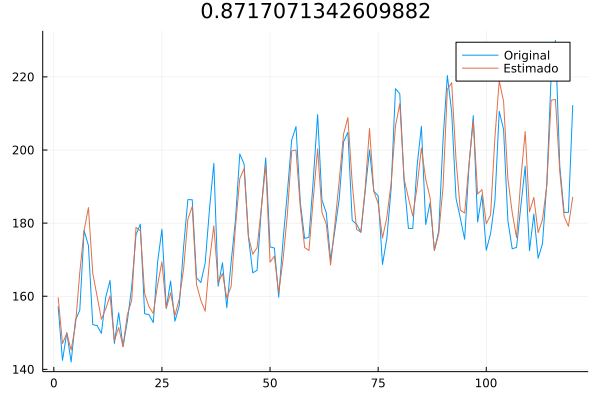

In [14]:
model = complete_model(y,[1,12],[12, 18],[1,1],3,1e8)
ST = value.(model[:estimate])
@show(value.(model[:beta]))
@show(value.(model[:theta]))
@show(value.(model[:phi]))
r = r_square(y[13:end], ST)
plot([y[13:end], ST],label=["Original" "Estimado"], title="$r")

## Forecast

mae(f, y, 120) = 10.373498238280044


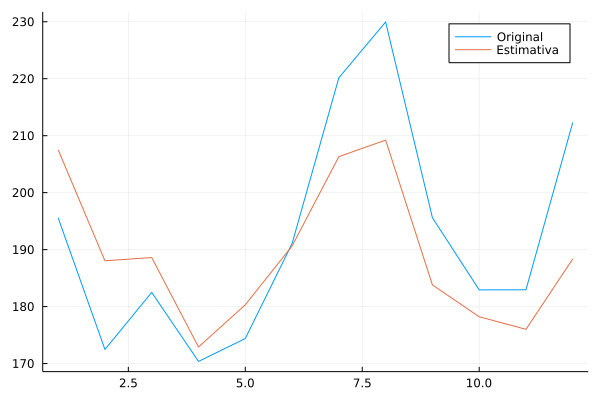

In [15]:


f, model = forecast(y,[1,12],[12, 18],[5,5],120, 5)
@show mae(f, y, 120)
plot([y[121:end], f[121:end]], label=["Original" "Estimativa"])

In [42]:
function choose_k(data::Vector{Float64}, K::Vector{Int} = [1], S::Vector{Int} = [8760], M::Vector{Int} = [1], T::Int = 0, B_list::Int64 = 1, BigM::Float64 = 1e3)    
    values = zeros(B_list)
    betas = zeros(length(K),B_list)
    thetas = zeros(sum(M),B_list)
    phis = zeros(sum(M),B_list)
    for B in 1:B_list
        f, model = forecast(data, K, S, M, T, B, BigM)
        values[B] = mae(f, y, 120)
        betas[:,B] = value.(model[:beta])[2:end]
        thetas[:,B] = value.(model[:theta])
        phis[:,B] = value.(model[:phi])
    end
    return values, betas, thetas, phis
end

choose_k (generic function with 7 methods)

In [43]:
values, betas, thetas, phis = choose_k(y,[1,2,11,12],[12, 18],[5,5],120, 30)

([10.834213405776552, 10.868173453514814, 10.776570020186686, 10.039359116194431, 10.373498238283391, 10.418532665736917, 9.950177568147106, 9.546519057377985, 9.157488490922741, 8.579062590739413  …  9.33781283709825, 9.317224603719893, 9.317224603719893, 9.317224603715959, 9.317224603715959, 9.317224603715959, 9.317224603715959, 9.317224603715959, 9.317224603715959, 9.317224603715959], [-0.0 -0.0 … 0.5223167589205048 0.5223167589205048; 9.797865052343423e-11 -1.0823058645590848e-10 … 0.08283243243060902 0.08283243243060902; -0.0 3.7929064243559617e-11 … -0.09081248378267799 -0.09081248378267799; 0.8995425650243981 0.8738687625129367 … 0.42809516396939046 0.42809516396939046], [-6.42060371282884e-11 -7.97933942678035e-10 … -2.067889504286292 -2.067889504286292; 2.07907080312983e-11 -1.2269930953569528e-9 … -990.1968711073754 -990.1968711073754; … ; -5.895022053178418e-11 5.865887087558106e-10 … -0.6903924936737367 -0.6903924936737367; -1.9334786509085584e-11 3.6294334475937177e-10 … 0

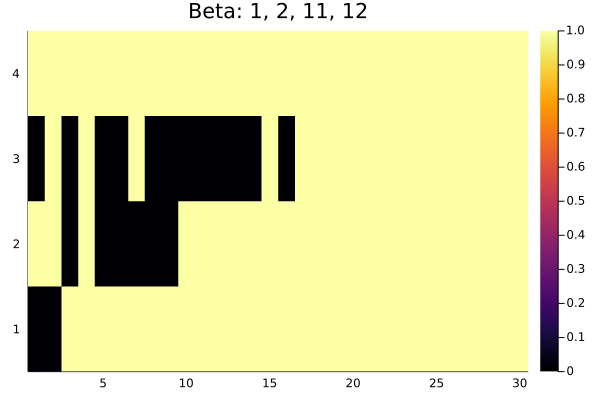

In [50]:
heatmap(betas.!=0.0, title="Beta: 1, 2, 11, 12")

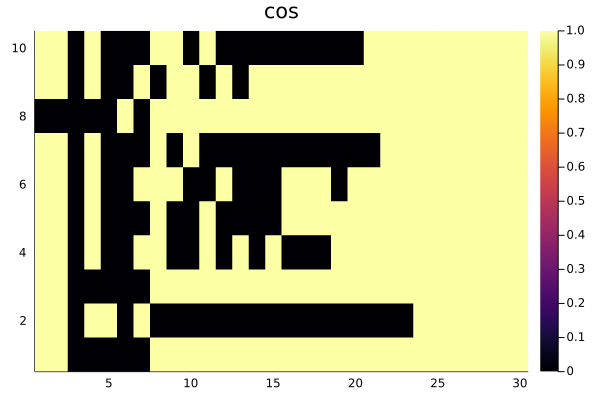

In [52]:
heatmap(thetas.!=0.0,title="cos")

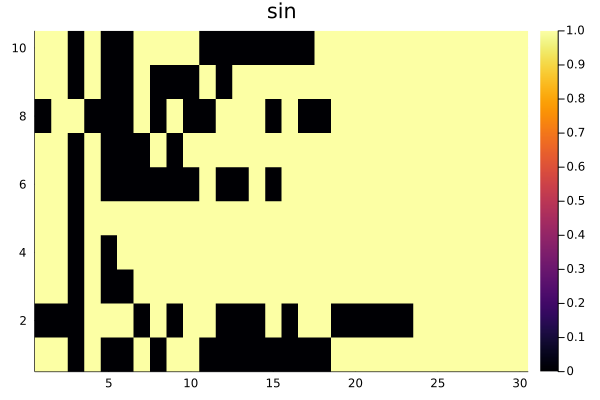

In [53]:
heatmap(phis.!=0.0,title="sin")

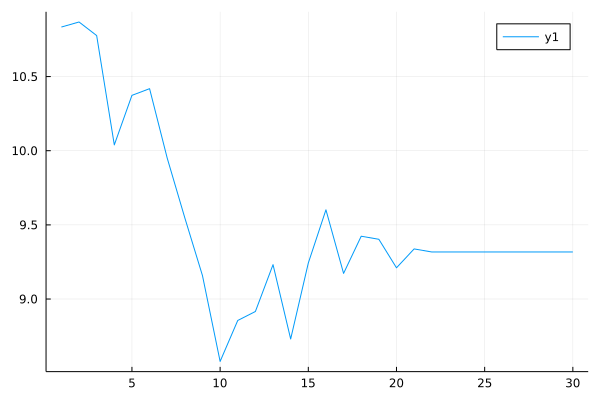

In [47]:
plot(values)